In [145]:
import re
import random
import pandas as pd
import hashlib

In [146]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [147]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,32.548472,3.254847,5.811997,10
DAX,208.540372,23.171152,32.344409,9
RAG Project,413.810724,82.762145,134.303945,5
"Jane Eyre, Bronte",679.270633,84.908829,125.612014,8
Azure VM + Developer,978.367031,28.775501,41.992677,34
Azure AD Authentication,1006.929037,83.910753,162.889508,12
TSQL,1108.768549,46.198690,66.774750,24
Logging in Python,1205.596249,86.114018,129.725030,14
Terraform,1730.102371,96.116798,156.623930,18
Azure Private DNS,1825.250384,96.065810,173.020449,19


# Histogram

sum of ages: ~56679.89


<Axes: >

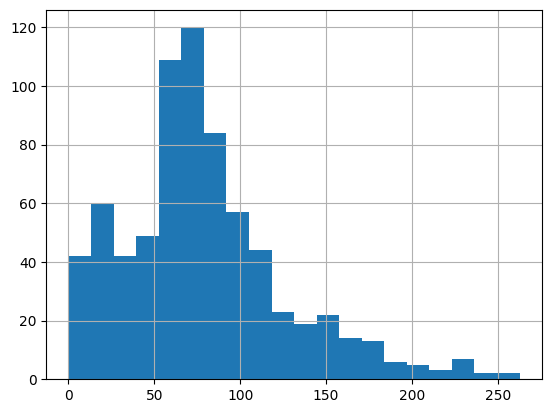

In [148]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~56679.89


<Axes: >

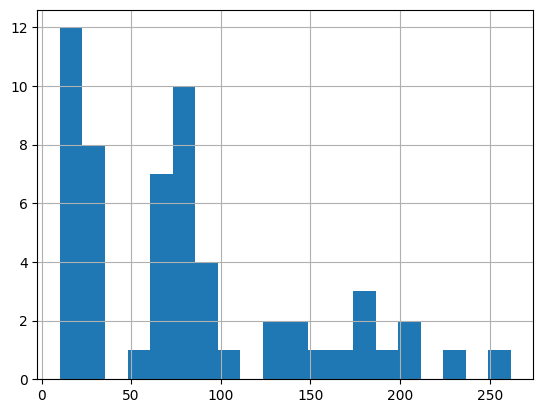

In [149]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [150]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [151]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [152]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [153]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [154]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [155]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [156]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [ ]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


## Age Mean

In [158]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [159]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [ ]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

Cards found: 723
Total card age: 56679.89


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
0,RAG Project,ASGI\nAsynchronous Server Gateway Interface — ...,8ba468f63a8eb59587a20b767f0fdf5e,134.303945,82.762145,134.303945,413.810724,0.084596,5,0,0,-134.303945
1,RAG Project,async / await\nKeywords in Python for writing ...,974b559f2a7ae9d18c854ae4d9c8a3a4,84.566384,82.762145,134.303945,413.810724,0.084596,5,1,0,-84.566384
2,RAG Project,Object ID (OID)\nUnique identifier for a user ...,457db37b12bdb9edd5c82054473c76ed,73.476821,82.762145,134.303945,413.810724,0.084596,5,2,0,-73.476821
3,RAG Project,auth_client\nA special fixture often defined i...,6f737b87b759709e2365a5d4597982c2,61.825185,82.762145,134.303945,413.810724,0.084596,5,3,0,-61.825185
114,RAG Project,Test Client\nA simulated web client that sends...,aed96e7baebb3c891bd3d059cc3e29ec,59.638389,82.762145,134.303945,413.810724,0.084596,5,4,0,-59.638389
4,"Jane Eyre, Bronte",Basin and Ewer\n(BAY-sin and YOO-er) A bowl (b...,a985a5826fd5d734c4090f3f9d253305,125.612014,84.908829,125.612014,679.270633,0.981027,8,0,0,-125.612014
5,"Jane Eyre, Bronte",Salubrious\n(suh-LOO-bree-uhs) Describing some...,a4e97a6bcfb2423b479db36526595e42,108.583622,84.908829,125.612014,679.270633,0.981027,8,1,0,-108.583622
6,"Jane Eyre, Bronte",Fillip\n(FIL-ip) A small but impactful boost o...,0a88c9b9810b59ec2c1def8c42e66c59,85.704664,84.908829,125.612014,679.270633,0.981027,8,2,0,-85.704664
7,"Jane Eyre, Bronte","Beldame\n(BEL-dame) An old woman, sometimes us...",d01e1e360b6b8ae184786b5c649e3009,84.171172,84.908829,125.612014,679.270633,0.981027,8,3,0,-84.171172
8,"Jane Eyre, Bronte",Piquant\n(PEE-kahnt) Having a pleasantly sharp...,df166b6d4a8d25f6f71abcb4b6cb16ed,79.769130,84.908829,125.612014,679.270633,0.981027,8,4,0,-79.769130



## Random

In [161]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [162]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
79,Asynchronous Python,Throttling\nLimiting concurrency in Python asy...,6d8d6c93bede788bb645c334badc4faa,262.705338,106.736805,262.705338,4376.209023,0.596621,41,0,0,-262.705338
94,Azure Developer Associate,You need to implement an Azure Storage lifecyc...,bf1b728607b958c3e992b65a2597c2b2,261.750066,82.643849,261.750066,4710.699369,0.616081,57,0,0,-261.750066
89,PnP PowerShell,Grant-PnPAzureADAppPermission (PnP.PowerShell)...,286cb0ddc5b9b680fc8f44ede5f20598,248.604974,89.202601,248.604974,4460.130053,0.135814,50,0,0,-248.604974
80,Asynchronous Python,async for (async iterator)\nUsed to iterate ov...,dbb74bcba577f12b06ddf83f9550d31b,243.832806,106.736805,262.705338,4376.209023,0.596621,41,1,0,-243.832806
39,Azure Functions + PP365,API Gateway Integration\nConnecting Azure Func...,d0210993b8fa777c35753f8d26d9c4a9,235.093352,115.221603,235.093352,2419.653670,0.970299,21,0,0,-235.093352
95,Azure Developer Associate,Which APIM configuration limits API calls per ...,f3ffbb13a887e8ec77e6ee870d9af2c7,233.940249,82.643849,261.750066,4710.699369,0.616081,57,1,0,-233.940249
99,Python,How do you resolve a relative path to an absol...,51bcf0bea82ec86eae6817d34b301707,232.833903,58.811035,232.833903,3528.662077,0.971837,60,0,0,-232.833903
59,PowerShell Modules,Install-Module\n\nDefinition: A cmdlet used to...,abd837efe7378e3e46b08d09a459cae3,231.867099,108.368284,231.867099,3467.785101,0.572303,32,0,0,-231.867099
60,PowerShell Modules,PSReadLine Module\n\nDefinition: A module that...,b41f499c95e1fc0bd9767a6315e4b432,231.584209,108.368284,231.867099,3467.785101,0.572303,32,1,0,-231.584209
40,Azure Functions + PP365,Async Programming (Asyncio)\nA programming par...,84ef9036376cd6bdf68c3b08fc358303,230.218159,115.221603,235.093352,2419.653670,0.970299,21,1,0,-230.218159


In [163]:
existing_cards.head(10).sum()

head                   RAG ProjectRAG ProjectRAG ProjectRAG ProjectRA...
body                   ASGI\nAsynchronous Server Gateway Interface — ...
hash                   8ba468f63a8eb59587a20b767f0fdf5e974b559f2a7ae9...
age                                                           897.651325
subject_mean_age                                              838.354869
subject_highest_age                                          1299.579795
subject_age_sum                                              5465.406783
head_random_roll                                                5.328115
frequency                                                             65
count                                                                 20
n_fold                                                                 0
neg_age                                                      -897.651325
dtype: object

In [164]:
existing_cards['age'].mean()

78.39542649646555